In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import scipy.signal as signal
from scipy import sparse
from scipy.sparse.linalg import spsolve

/home/apk/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#import glob
#print glob.glob('/home/apk/id6Day2-20190503T211715Z-001/id6Day2/*.hdf5')

In [2]:
arr=list(os.listdir('/home/apk/id6Day7-20190503T212715Z-001/id6Day7'))
arr.sort()
print arr[len(arr)-14:]

['a2018.10.24_10.58.25.hdf5', 'aa2018.10.24_12.17.07.hdf5', 'b2018.10.24_11.01.08.hdf5', 'bb2018.10.24_12.19.25.hdf5', 'c2018.10.24_11.01.51.hdf5', 'cc2018.10.24_12.20.02.hdf5', 'd2018.10.24_11.03.05.hdf5', 'dd2018.10.24_12.21.21.hdf5', 'e2018.10.24_11.03.39.hdf5', 'ee2018.10.24_12.22.02.hdf5', 'f2018.10.24_11.06.02.hdf5', 'ff2018.10.24_12.24.26.hdf5', 'g2018.10.24_11.06.26.hdf5', 'gg2018.10.24_12.25.10.hdf5']


In [3]:
arr1=(list(os.listdir('/home/apk/id6Day1-20190503T170539Z-001/id6Day1')))
arr2=(list(os.listdir('/home/apk/id6Day2-20190503T211715Z-001/id6Day2')))
arr7=(list(os.listdir('/home/apk/id6Day7-20190503T212715Z-001/id6Day7')))
arr30=(list(os.listdir('/home/apk/id6Day30-20190503T212316Z-001/id6Day30')))
arr90=(list(os.listdir('/home/apk/id6Day90-20190503T213214Z-001/id6Day90')))
arr1.sort()
arr2.sort()
arr7.sort()
arr30.sort()
arr90.sort()
efile=[]
efile.append(arr1[len(arr1)-14:])
efile.append(arr2[len(arr2)-14:])
efile.append(arr7[len(arr7)-14:])
efile.append(arr30[len(arr30)-14:])
efile.append(arr90[len(arr90)-14:])
print efile[0][1]

aa2018.10.06_12.57.24.hdf5


In [4]:
def CAR(samples):
    s=[]
    for i in range(0, len(samples)):
        s.append((sum(samples))/64.0)
    
    sample=samples-s
    return sample, s

In [5]:
def elliptic_bandpass(order, rp, rs, lowcut, highcut):
    fs=256
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.ellip(order, rp, rs, [low, high], btype='bandpass', analog=False, output='ba')
    return b, a

In [6]:
def baseline_als(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    #D = sparse.csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [7]:
spr_channels=[0,2,7,9,11,13,15,62,25,27,29,31,33,63,43,45,47,49,51,57,59]
spr_channel_names=['fp1','fp2','f7','f3','fz','f4','f8','A1','T3','C3','Cz','C4','T4','A2','T5','P3','Pz','P4','T6'
                  ,'O1','O2']

In [8]:
def power(x):
    x=1.0*(x)
    return sum(x**2)/len(x)

In [9]:
path="id6Day90-20190503T213214Z-001"
plt.rcParams["figure.figsize"] = [25,16]

In [20]:
def subpower(efile, spr_channel):
    for i in range (0, len(efile[0]), 2):
        activity=str(efile[0][i][0:4])
        eeg=[]
        for j in range(0, len(efile)):
            eeg.append(h5py.File(efile[j][i],mode='r'))
            eeg.append(h5py.File(efile[j][i+1],mode='r'))
        samples=[]
        sampletime1=[]
        for j in range(0, len(eeg)):
            sam=[]
            sa=np.array(eeg[j]["RawData"]['Samples'])
            sa=sa.T
            sa,_=CAR(sa)
            samples.append(sa)
            sampletime = np.array(eeg[j]['AsynchronData']["Time"])
            sam.append(int(sampletime[0]))
            sam.append(int(sampletime[1]))
            sampletime1.append(sam)

        freq=[[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 100]]
        fs=256
        order=4
        rp=0.5
        rs=30
        powe=[]
        for j in range(0, len(samples)):
            print 1
            alpha=[]
            beta=[]
            gamma=[]
            delta=[]
            theta=[]
            p=[]
            k = spr_channel
            b, a = elliptic_bandpass(order, rp, rs, freq[0][0], freq[0][1])
            delta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[1][0], freq[1][1])
            theta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[2][0], freq[2][1])
            alpha.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[3][0], freq[3][1])
            beta.append(signal.filtfilt(b, a, samples[j][k], padlen=0))
            b, a = elliptic_bandpass(order, rp, rs, freq[4][0], freq[4][1])
            gamma.append(signal.filtfilt(b, a, samples[j][k], padlen=0))

            k=0
            alpha[k]=alpha[k][sampletime1[j][0]:sampletime1[j][1]]
            beta[k]=beta[k][sampletime1[j][0]:sampletime1[j][1]]
            gamma[k]=gamma[k][sampletime1[j][0]:sampletime1[j][1]]
            delta[k]=delta[k][sampletime1[j][0]:sampletime1[j][1]]
            theta[k]=theta[k][sampletime1[j][0]:sampletime1[j][1]]
            za=baseline_als(alpha[k], 10**4, 0.1, 10)
            alpha[k]=alpha[k]-za
            za=baseline_als(beta[k],10**4, 0.1, 10)
            beta[k]=beta[k]-za
            za=baseline_als(gamma[k], 10**4, 0.1, 10)
            gamma[k]=gamma[k]-za
            za=baseline_als(theta[k], 10**4, 0.1, 10)
            theta[k]=theta[k]-za
            za=baseline_als(delta[k], 10**4, 0.1, 10)
            delta[k]=delta[k]-za

            
            p.append(power(delta[k]))
            p.append(power(theta[k]))
            p.append(power(alpha[k]))
            p.append(power(beta[k]))
            p.append(power(gamma[k]))
            #p=p/max(p)
            print p
            powe.append(p)

        x_axis=['delta','theta','alpha','beta','gamma']
        cnl_name=spr_channel_names[spr_channel]
        fig=plt.figure()
        plot=fig.add_subplot(5,2,1)
        plt.bar(x_axis, powe[0])
        plt.title("Day 1- before"+cnl_name)

        plot=fig.add_subplot(5,2,2)
        plt.bar(x_axis, powe[1])
        plt.title("Day 1- after"+cnl_name)

        plot=fig.add_subplot(5,2,3)
        plt.bar(x_axis, powe[2])
        plt.title("Day 2- before"+cnl_name)

        plot=fig.add_subplot(5,2,4)
        plt.bar(x_axis, powe[3])
        plt.title("Day 2- after"+cnl_name)

        plot=fig.add_subplot(5,2,5)
        plt.bar(x_axis, powe[4])
        plt.title("Day 7- before"+cnl_name)

        plot=fig.add_subplot(5,2,6)
        plt.bar(x_axis, powe[5])
        plt.title("Day 7- after"+cnl_name)

        plot=fig.add_subplot(5,2,7)
        plt.bar(x_axis, powe[6])
        plt.title("Day 30- before"+cnl_name)

        plot=fig.add_subplot(5,2,8)
        plt.bar(x_axis, powe[7])
        plt.title("Day 30- after"+cnl_name)

        plot=fig.add_subplot(5,2,9)
        plt.bar(x_axis, powe[8])
        plt.title("Day 90- before"+cnl_name)

        plot=fig.add_subplot(5,2,10)
        plt.bar(x_axis, powe[9])
        plt.title("Day 90- after"+cnl_name)

        plt.tight_layout()
        plt.savefig(path+'/'+activity+'.png')

1
[7.876246615086688, 32.643596352229686, 19.902505216845455, 6.520093046551764, 2.935656518469145]
1
[12.304472003984818, 41.214343335594485, 20.70127394427811, 5.06707795603497, 1.0404324562675784]
1
[3.5722837075298615, 11.339073803301487, 13.540723217425972, 2.7133178349517393, 0.837606270202259]
1
[3.1896198367694133, 13.36468585841301, 16.487948010277876, 2.846417502423119, 0.7423544724514]
1
[50.937971436425855, 54.40164780165401, 29.81192062948421, 9.528208744853352, 61334.14416380089]
1
[37.297352942171315, 47.73368296728923, 23.739212425441966, 8.218403712619027, 78817.39191815308]
1
[5.376328655172631, 19.077020664723772, 36.62130484372457, 6.811880692640031, 1.591820048495887]
1
[5.9124043457974516, 17.062863940028226, 32.97161031021554, 7.203795376846054, 2.0090346105588073]
1
[8.050158329001922, 9.637549084298056, 22.395828873272407, 6.479716693192433, 2.3134345828564826]
1
[3.3729868337037994, 10.579117204427801, 27.982844021745997, 7.082186313166391, 2.1571411945679158]

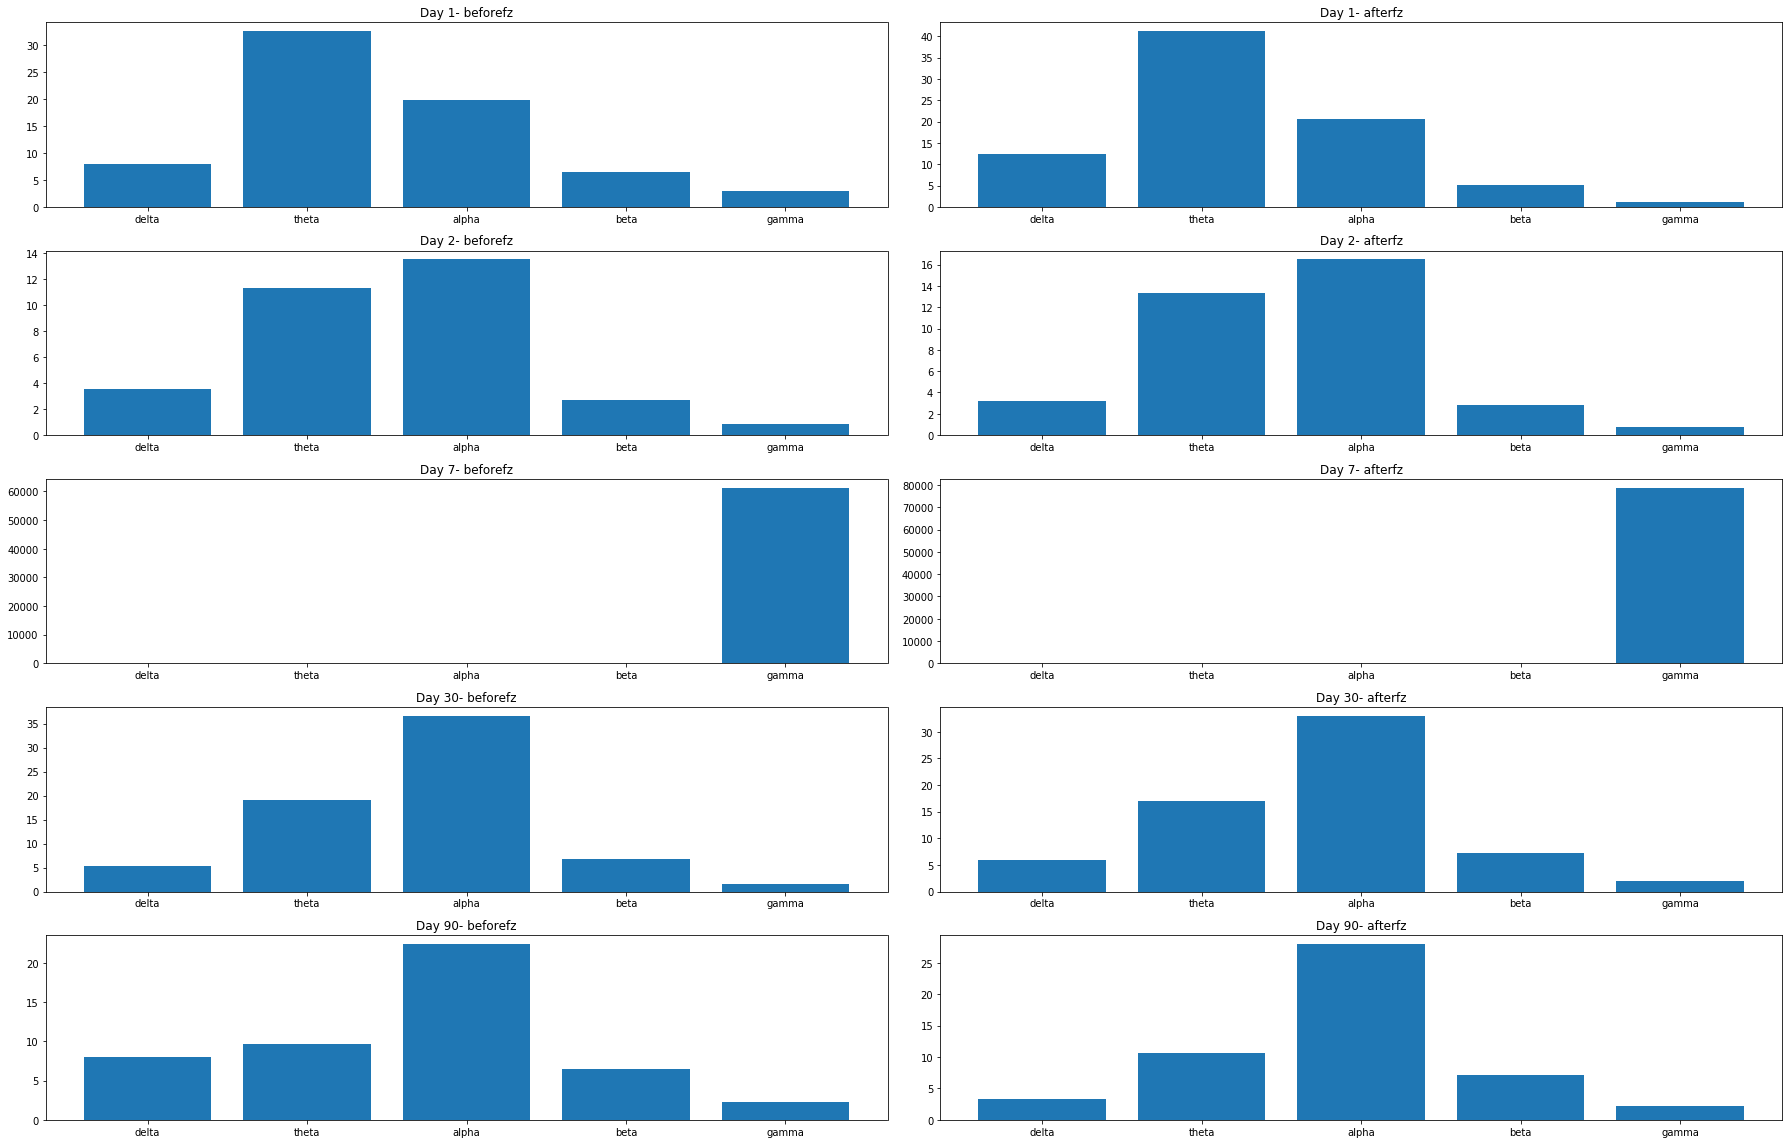

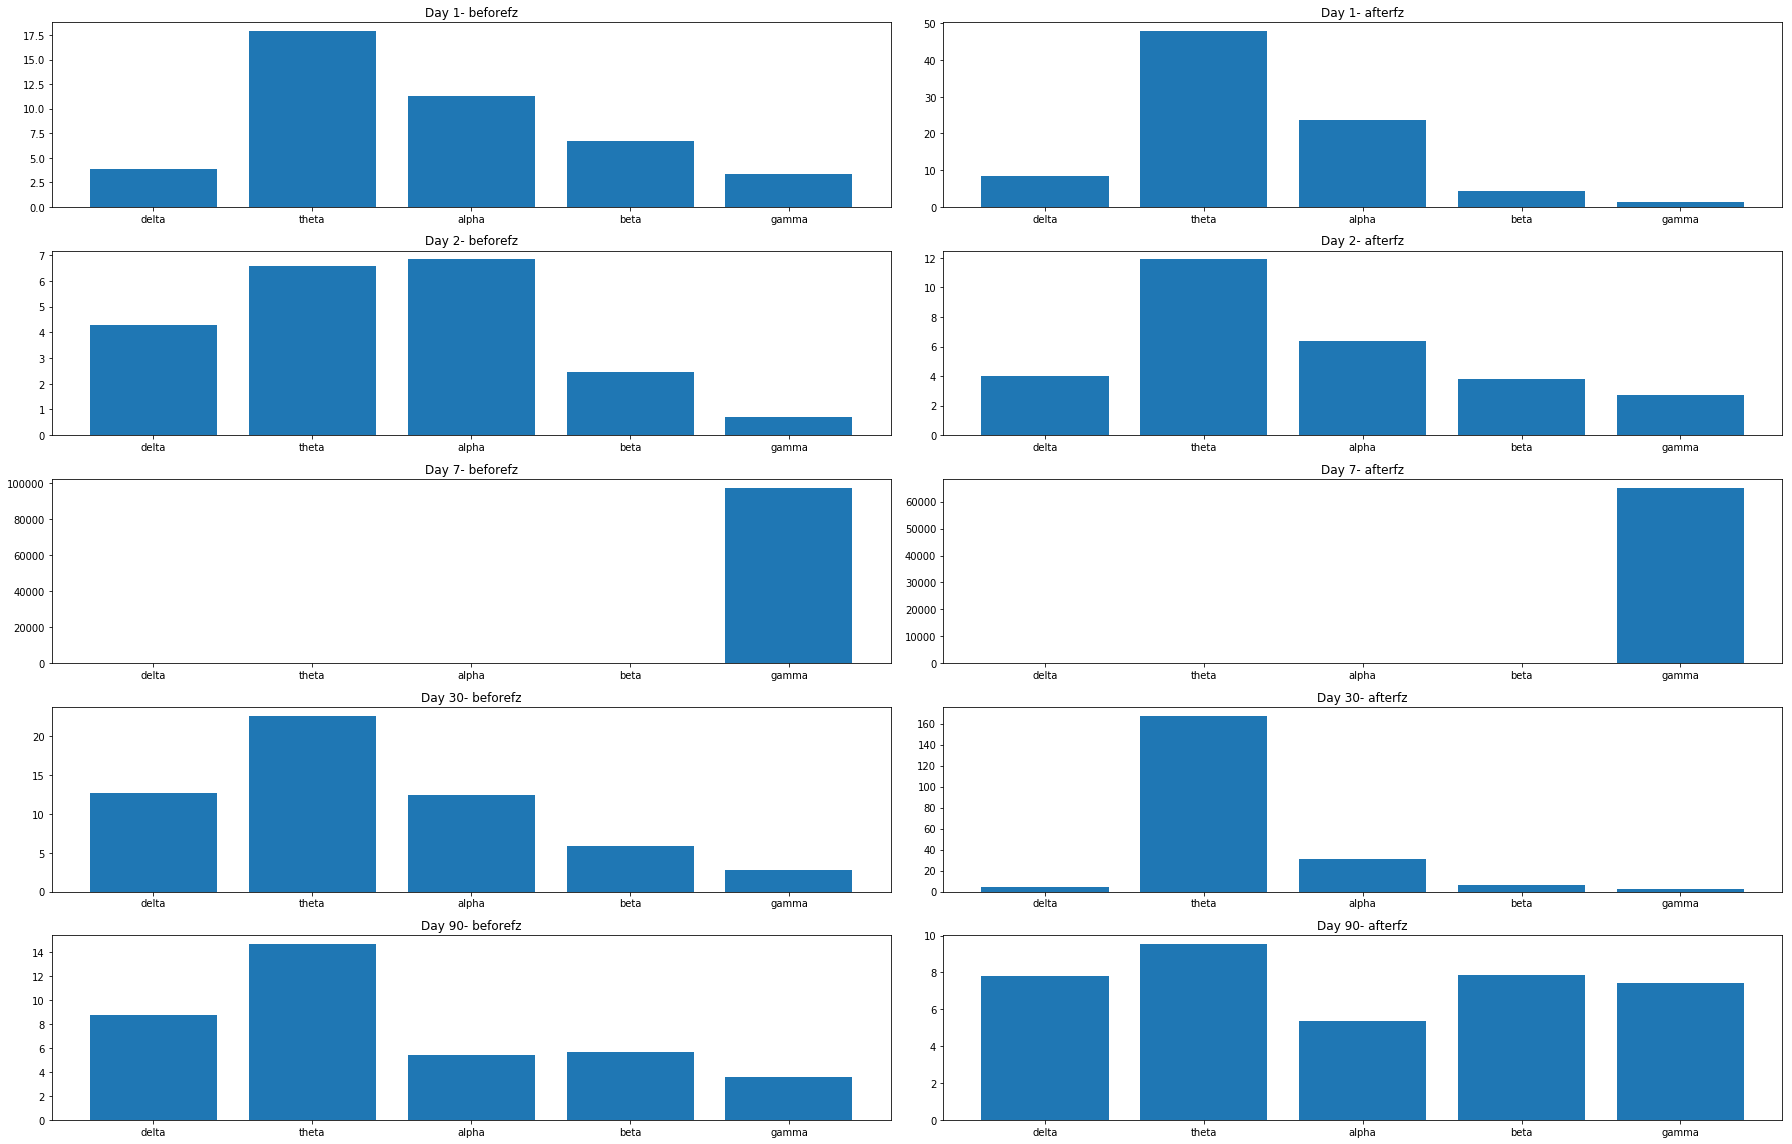

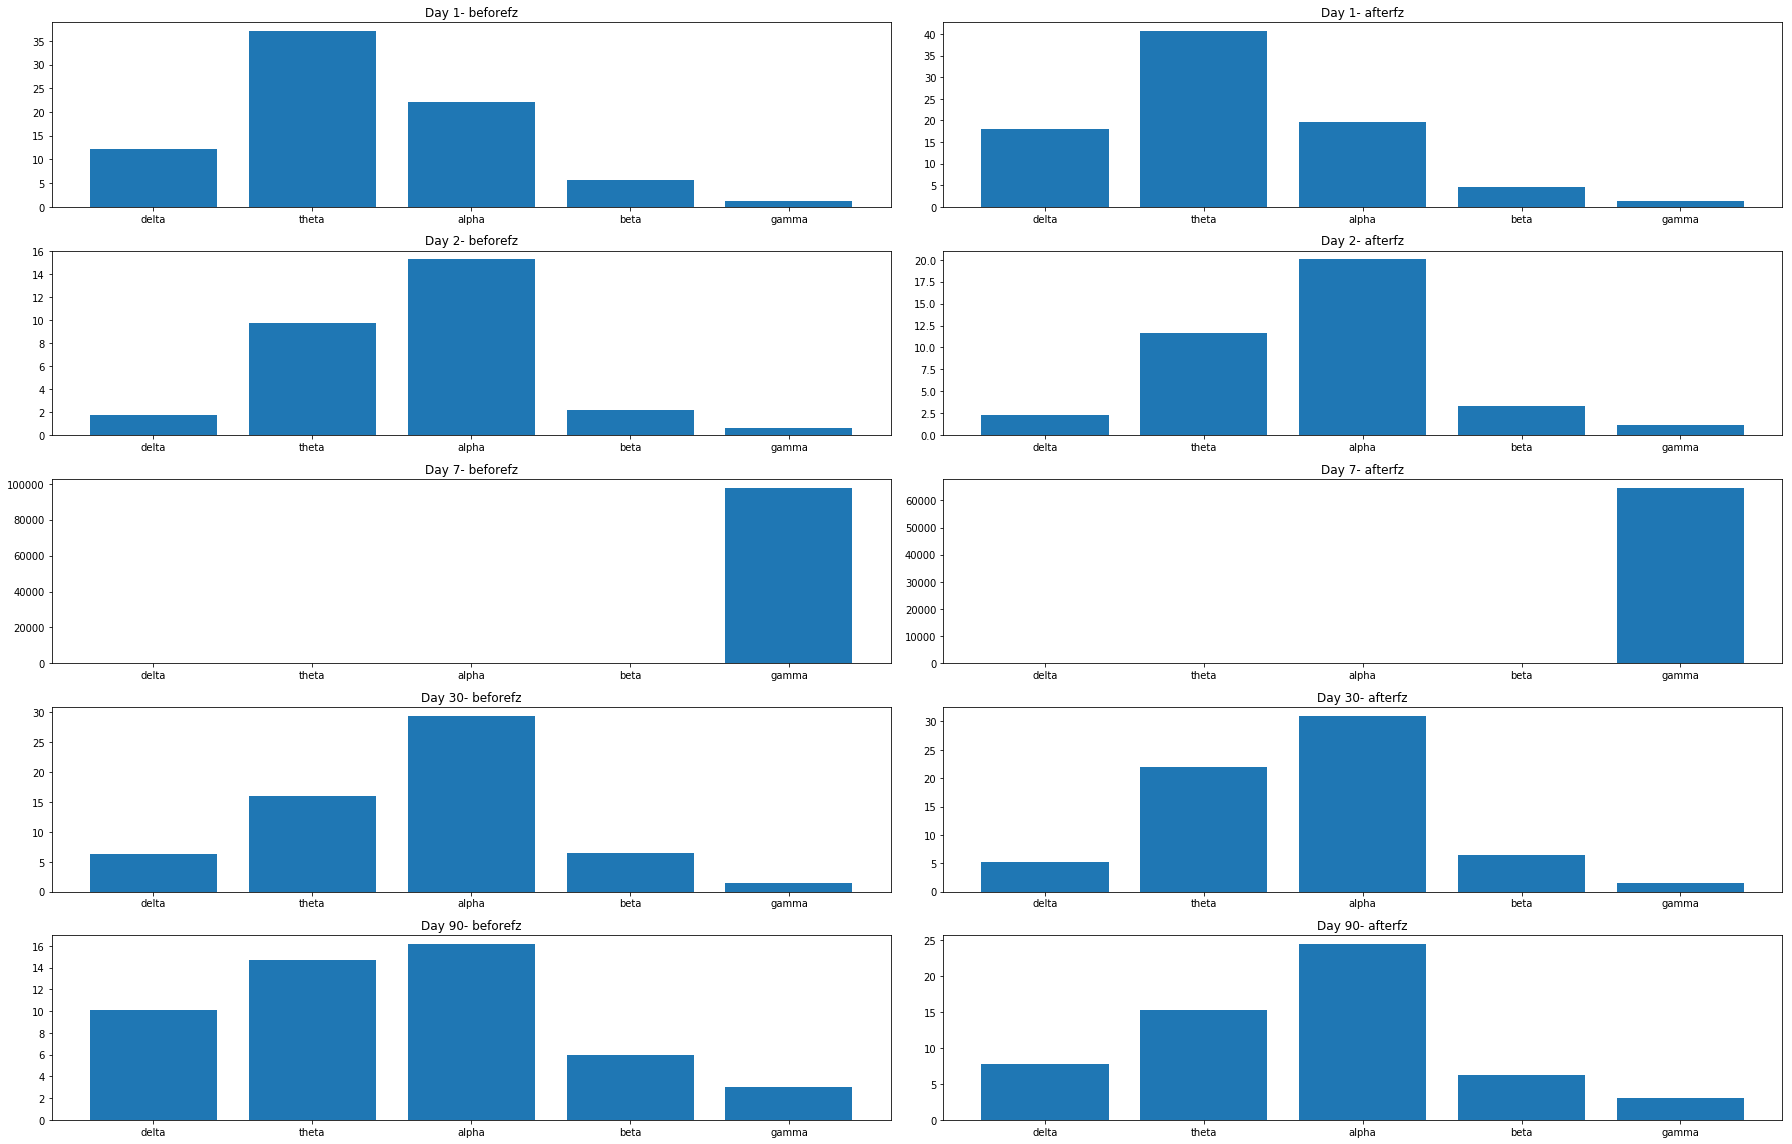

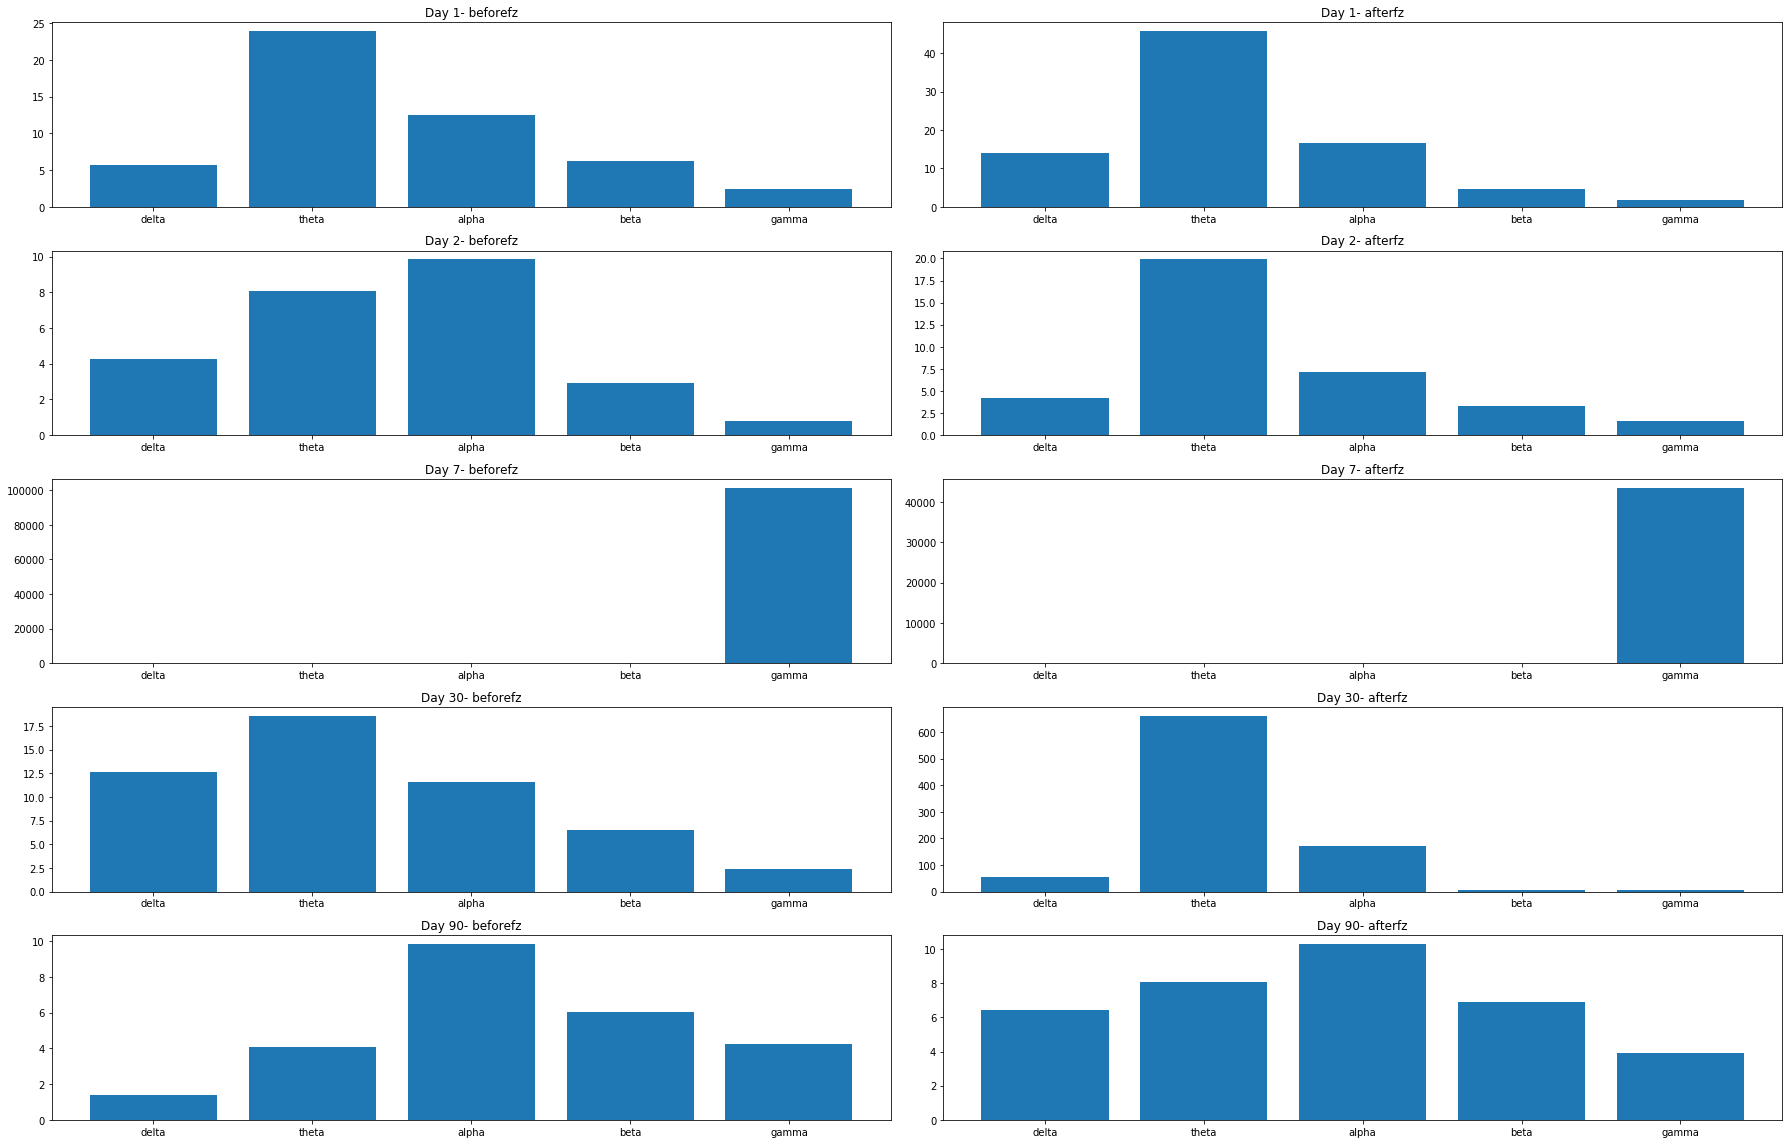

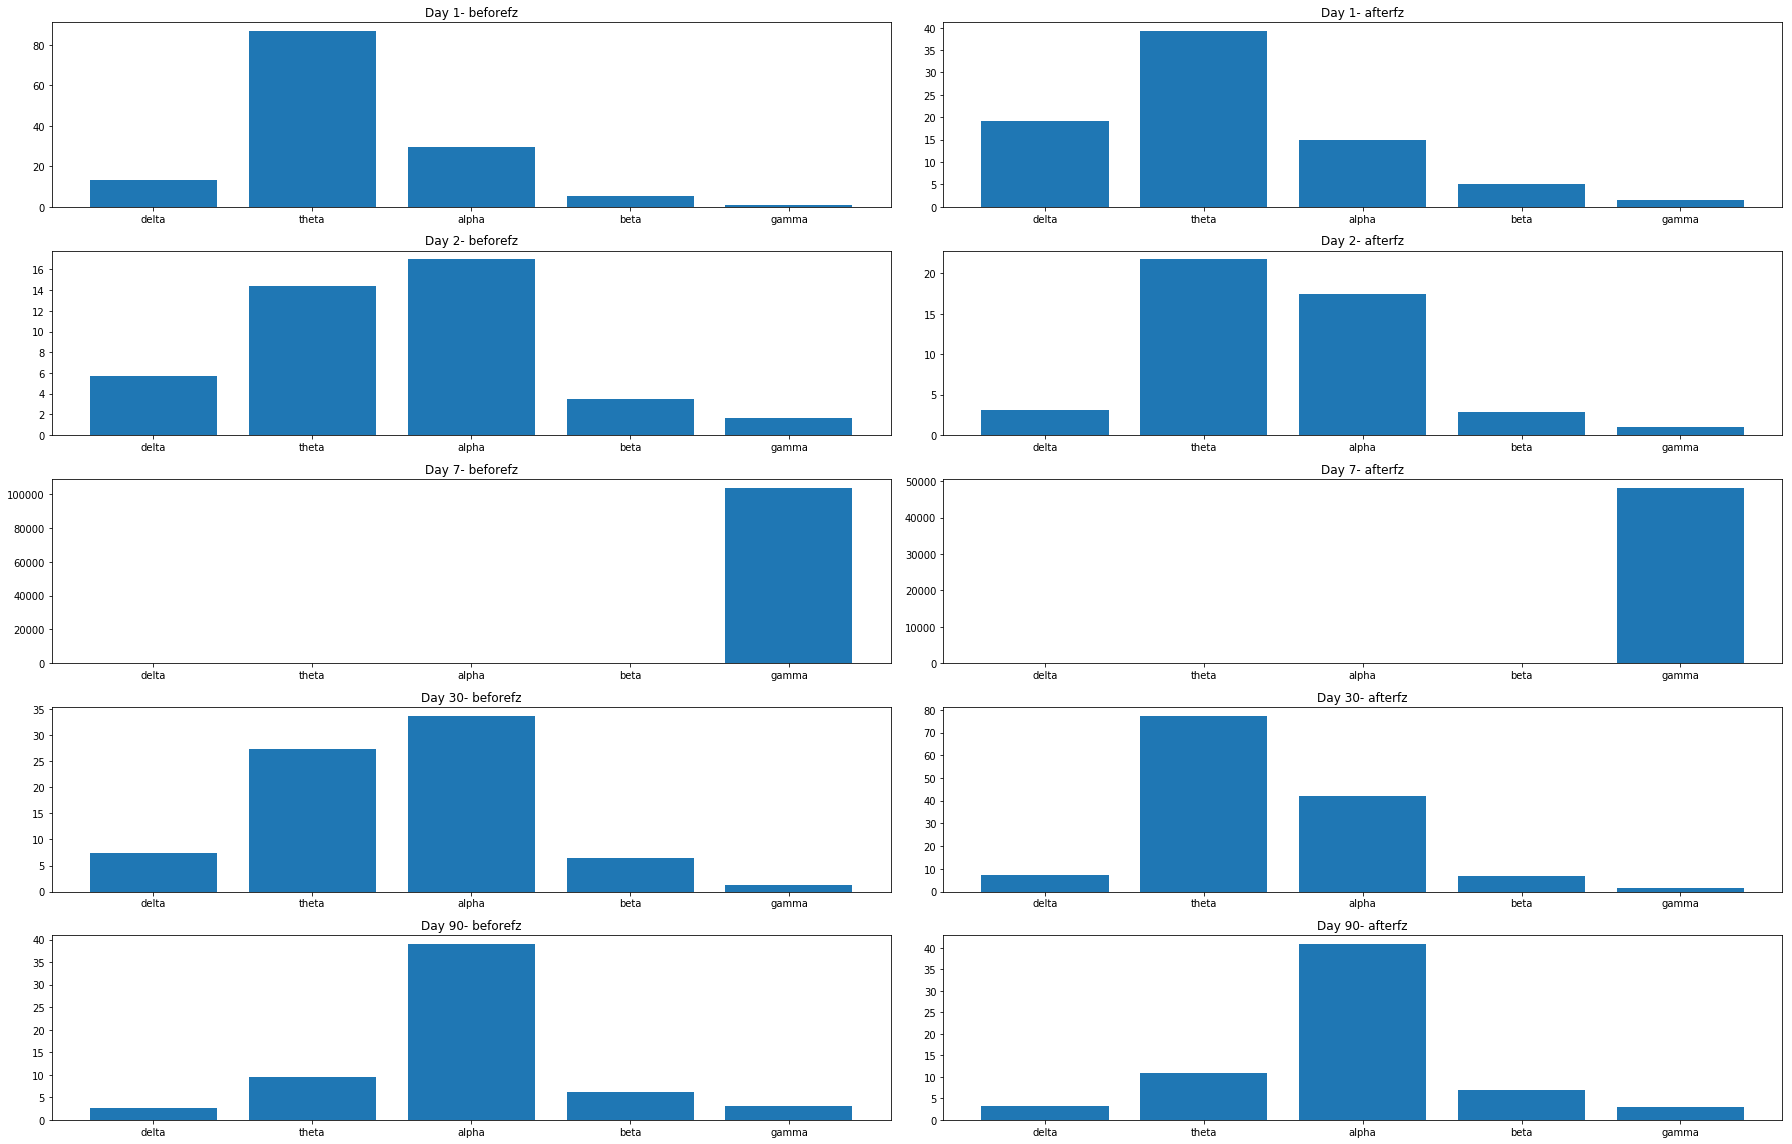

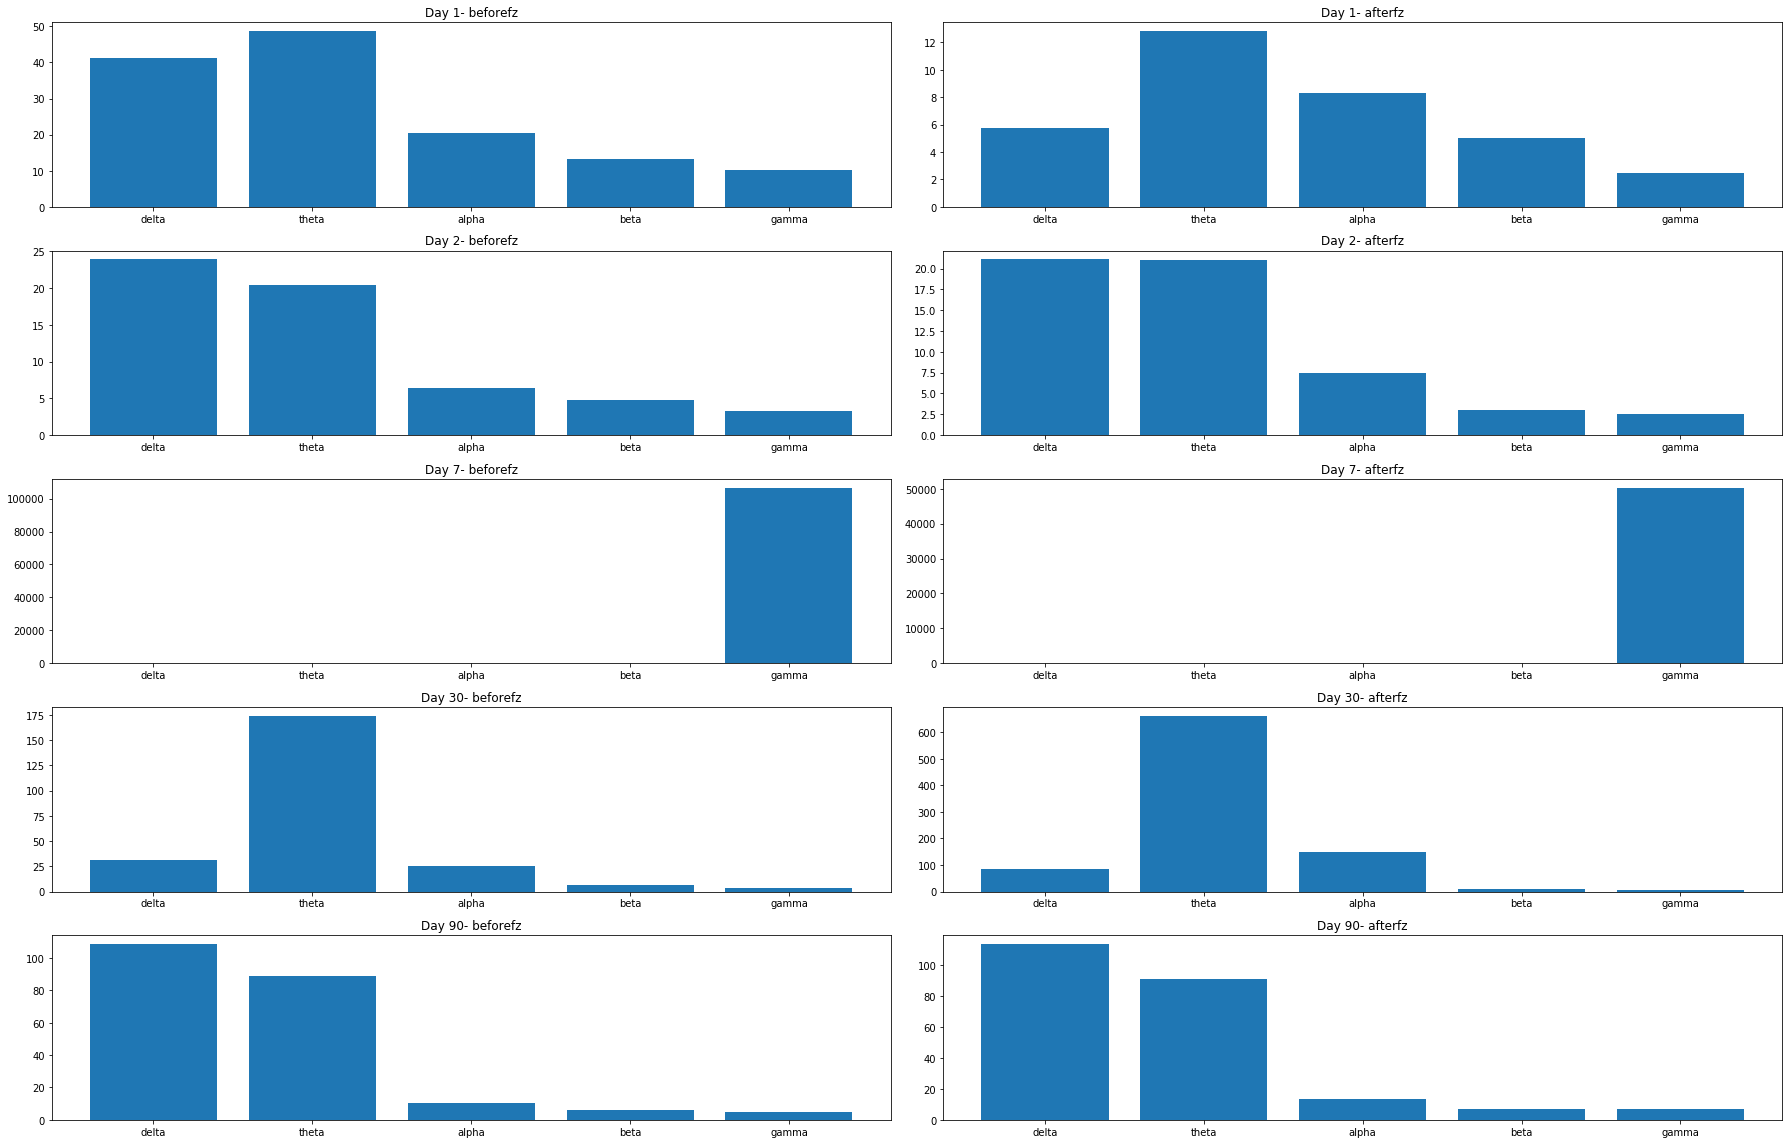

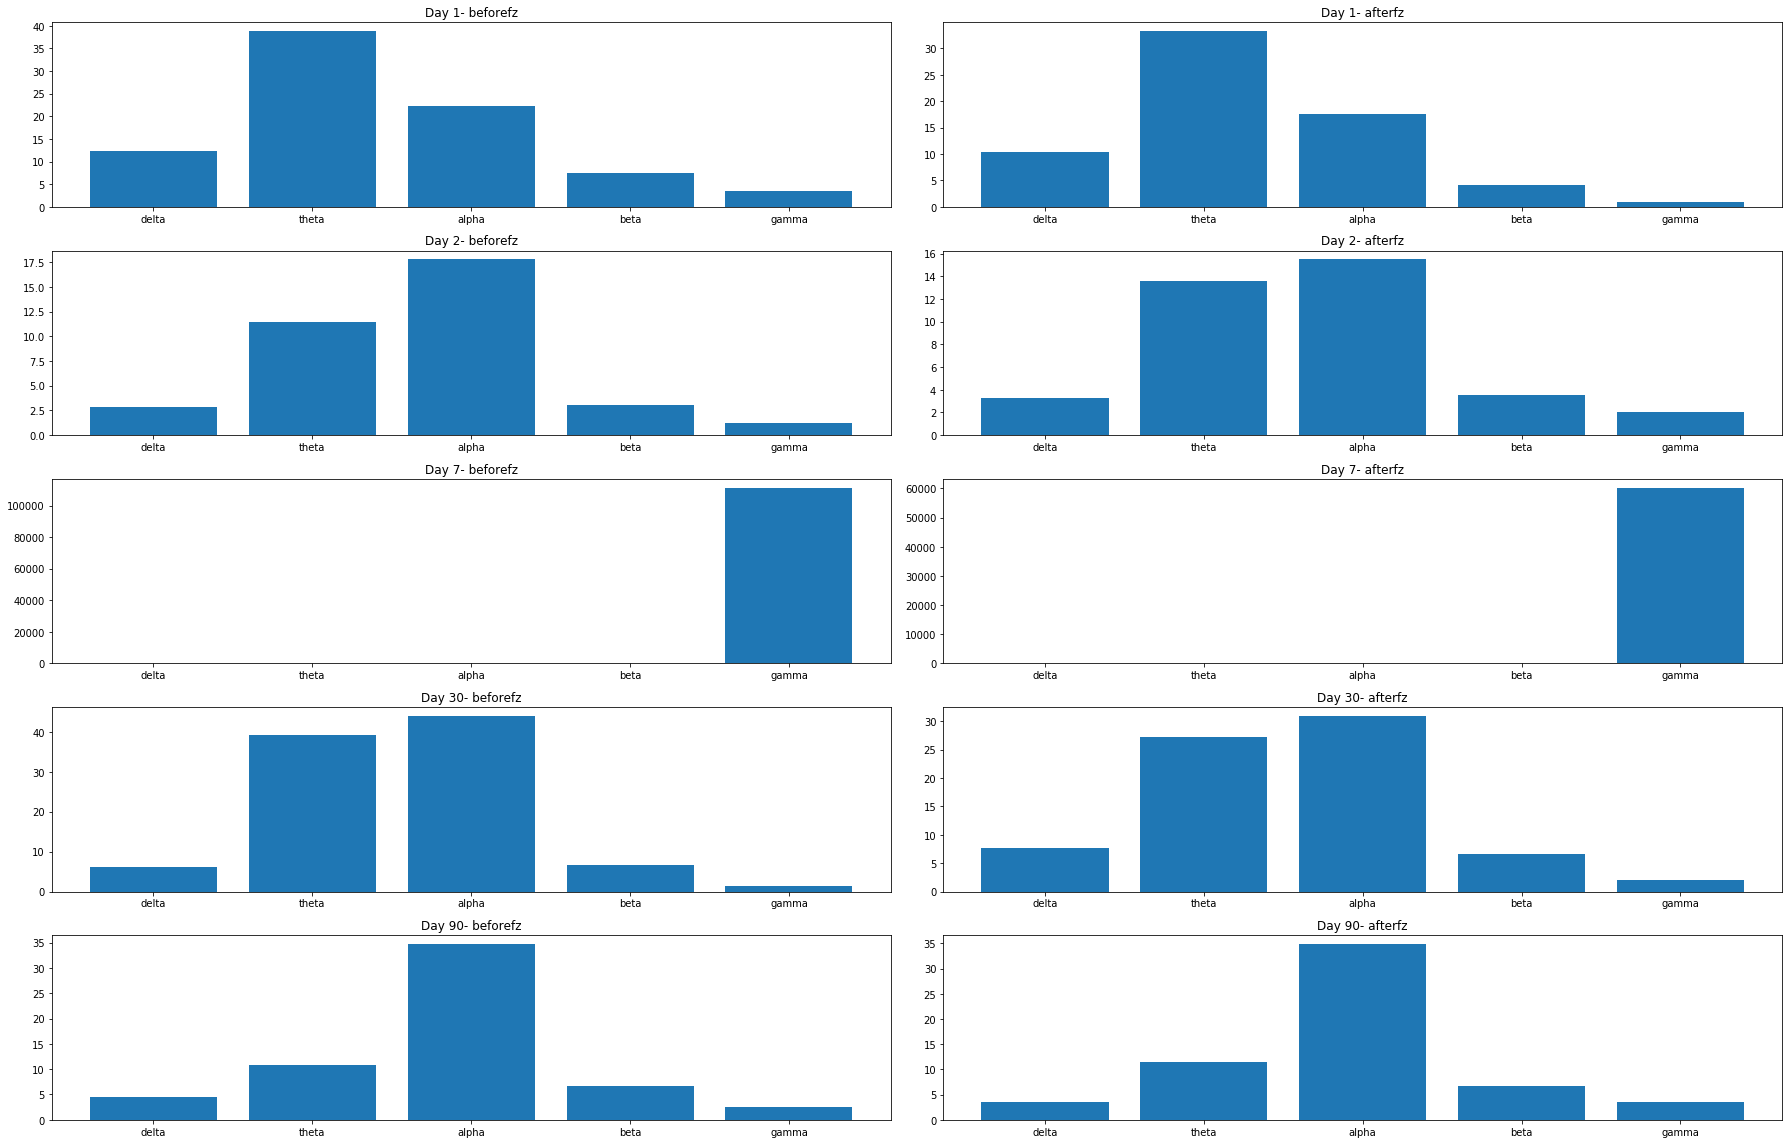

In [21]:
subpower(efile, 4)

In [ ]:
for i in spr_channels:
    subpower(efile, i)